In [8]:
#importing the required modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import anderson, wilcoxon, ttest_ind

In [2]:
#reading the RepeatMasker output files into pandas dfs and set the genome parts (chromosomes and scaffolds) as indices
upstream_repeats=pd.read_csv('../results/upstream_repeats.tsv', sep='\t')
upstream_repeats=upstream_repeats.set_index('genoName')
downstream_repeats=pd.read_csv('../results/downstream_repeats.tsv', sep='\t')
downstream_repeats=downstream_repeats.set_index('genoName')
sample_repeats=pd.read_csv('../results/genomic_repeats.tsv', sep='\t')
sample_repeats=sample_repeats.set_index('genoName')

In [3]:
#get common repetitions in all three dataset (upstream, downstream, genome)
common_repeats = pd.Series(list(set(upstream_repeats['repName'].unique()) &
                             set(downstream_repeats['repName'].unique()) &
                             set(sample_repeats['repName'].unique())))


In [5]:
#get the number of common repetitions per chromosomes and scaffolds
def get_repeatnumber(chromosome, repname):
    upstream_subdf = upstream_repeats.loc[chromosome]
    downstream_subdf = downstream_repeats.loc[chromosome]
    sample_subdf = sample_repeats.loc[chromosome]
    return [list(upstream_subdf['repName']).count(repname),
           list(downstream_subdf['repName']).count(repname),
           list(sample_subdf['repName']).count(repname)]

In [6]:
#empty series for the repetitions
repeatnumbers = pd.Series(index = common_repeats, dtype = str)

In [9]:
#get the repeatnumber of every common repeats
for common_repeat in common_repeats:
    chromosomes = pd.Series(list(set(np.unique(sample_repeats.index.values))&
                           set(np.unique(upstream_repeats.index.values))&
                           set(np.unique(downstream_repeats.index.values))))
    samples = chromosomes.apply(get_repeatnumber, args = (common_repeat,))
    upstream_reps = []
    samples.apply(lambda sample : upstream_reps.append(sample[0]))
    downstream_reps = []
    samples.apply(lambda sample : downstream_reps.append(sample[1]))
    sample_reps = []
    samples.apply(lambda sample : sample_reps.append(sample[2]))
    repeatnumbers[common_repeat] = [upstream_reps, downstream_reps, sample_reps]

In [10]:
#function for the statistical analysis of repetitions
#upstream_repetitions = nested_list[0]
#downstream_repetitions = nested_list[1]
#sample_repetitions = nested_list[2]
def statistical_analysis(nested_list, which):
    sample1 = nested_list[which[0]]
    sample2 = nested_list[which[1]]
    norm1 = anderson(sample1)
    norm2 = anderson(sample2)
    stat1 = norm1[0]
    stat2 = norm2[0]
    critical_value1 = norm1[1][2]
    critical_value2 = norm2[1][2]
    if (stat1 > critical_value1) or (stat2 > critical_value2):
        try:
            significance = wilcoxon(sample1, sample2)[1]
            return significance
        except ValueError:
            pass
    else:
        try:
            significance = ttest_ind(sample1, sample2)[1]
            return significance
        except ValueError:
            pass

In [12]:
#statistics of upstream and downstream repetitions
upstream_downstream_stat = repeatnumbers.apply(statistical_analysis, args = ([0,1],))
#statistics of upstream and sample repetitions
upstream_sample_stat = repeatnumbers.apply(statistical_analysis, args = ([0,2],))
#statistics of downstream and sample repetitions
downstream_sample_stat = repeatnumbers.apply(statistical_analysis, args = ([1,2],))

In [13]:
#get the repeat category for every repeats
repeat_categories = pd.Series(repeatnumbers.index.values)
repeat_classes = repeat_categories.apply(lambda category : upstream_repeats.loc[upstream_repeats['repName'] == category]['repClass'].unique()[0])
repeat_classes.index = repeatnumbers.index.values

In [14]:
#invert repeat categories
repeats = pd.Series(repeat_classes.index.values)
repeats.index = repeat_classes

In [16]:
#get individual repeats for all repeat classes
repeat_families = pd.Series(repeat_classes.unique()).apply(lambda repeat_class:repeats[repeat_class].tolist())
repeat_families.index=repeat_classes.unique()

In [17]:
#get the new ordered header
def get_header(repeat_list):
    global header
    header += repeat_list

In [18]:
header = []
repeat_families.apply(get_header)

Simple_repeat     None
LINE              None
SINE              None
tRNA              None
LTR               None
DNA               None
Low_complexity    None
dtype: object

In [19]:
#create dataframe from the significance values
df = pd.DataFrame([upstream_downstream_stat,
upstream_sample_stat,
downstream_sample_stat])
df = df[header]
df.index = (['upstream_downstream',
'upstream_sample',
'downstream_sample'])

In [20]:
#function for drawing brackets to annotate each repeat family
def draw_brace(ax, xspan, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:resolution//2+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = ymin + (.15*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., ymin+.2*yspan, text, ha='center', va='bottom')

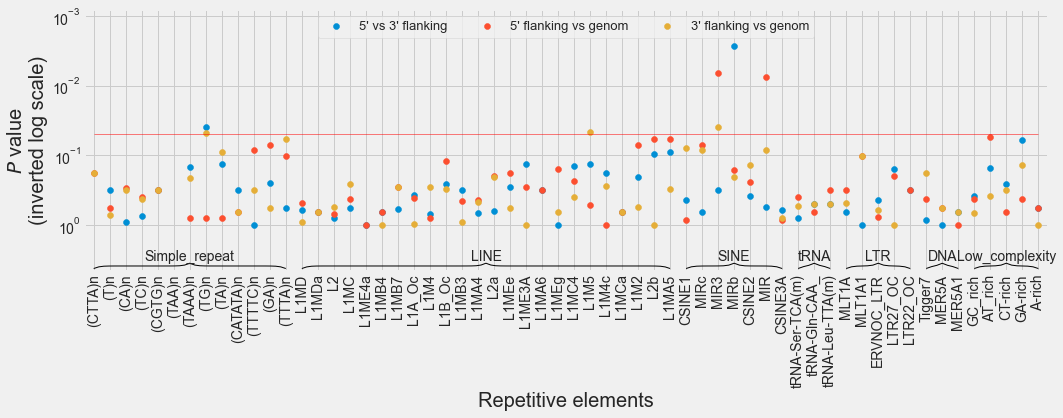

In [26]:
#visualizing
plt.style.use('fivethirtyeight')
bracket_start=0
fig, axes = plt.subplots(1, 1, figsize = (15,6))
upstream_downstream = axes.scatter(x = df.columns.values, y = df.loc['upstream_downstream'])
upstream_sample = axes.scatter(x = df.columns.values, y = df.loc['upstream_sample'])
downstream_sample = axes.scatter(x = df.columns.values, y = df.loc['downstream_sample'])
axes.plot(df.columns.values, (len(df.columns.values) * [0.05]), 'r',linewidth=0.5)
axes.legend((upstream_downstream, upstream_sample, downstream_sample),
          ("5' vs 3' flanking", "5' flanking vs genom",
           "3' flanking vs genom"),
           fontsize = 13,
           ncol = 3,
           loc = 'upper center')
axes.set_ylabel('$\it{P}$ value\n(inverted log scale)', fontsize = 20)
axes.set_xlabel('Repetitive elements', fontsize = 20)
plt.margins(x = 0.01)
plt.xticks(rotation = 90)
plt.yscale('log')
plt.ylim([10**-3.1, 10**0.65])
plt.gca().invert_yaxis()
for index, repeat_family in enumerate(repeat_families):
    bracket_end=(bracket_start+len(repeat_family))-1
    draw_brace(axes, (bracket_start,bracket_end),repeat_families.index.values[index])
    bracket_start+=len(repeat_family)
plt.tight_layout()